In [1]:
from matplotlib import animation
import numpy as np
import multiprocessing as mp
import logging
logger = mp.log_to_stderr(logging.INFO)
import time
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
import os
import datetime
import matplotlib as mpl
import subprocess
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature

from wetterdienst import Wetterdienst
from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset, DwdObservationPeriod, DwdObservationResolution

from datetime import datetime, timedelta
import datetime as dt




import pandas as pd

import smopy
import os

def station_temp(name, start_date, end_date):
    request = DwdObservationRequest(parameter=[DwdObservationDataset.TEMPERATURE_AIR],
                                resolution=DwdObservationResolution.MINUTE_10,
                                start_date=start_date,
                                end_date=end_date,
                                ).filter_by_name(name=name)

    df_res = request.values.all().df.dropna()

    df_Temp=df_res[df_res.parameter=="temperature_air_mean_200"].drop(['dataset', 'parameter', 'quality'], axis=1)
    df_Temp.rename(columns={'value':'T'}, inplace=True)
    df_dew=df_res[df_res.parameter=="temperature_dew_point_mean_200"].drop(['station_id', 'dataset', 'parameter', 'quality'], axis=1)
    
    df_dew.rename(columns={'value':'Td'}, inplace=True)
    
    df_Temp.set_index(pd.DatetimeIndex(df_Temp['date']), inplace=True)
    
    
    df_dew.set_index(pd.DatetimeIndex(df_Temp['date']), inplace=True)
    
    df_out=df_Temp.merge(df_dew, how='left', left_index=True, right_index=True)
    df_out["time"]=pd.to_datetime(df_Temp.date, format="%Y-%m-%d %H:%M:%S%z").dt.tz_localize(None)
    #df_out["SEC"]=pd.to_timedelta(df_Temp.date).dt.total_seconds()
    df_out.set_index(df_out["time"], inplace=True)
    #df_out.drop(["date"], axis=1)
    #df_out.set_index("time", inplace=True)
    df_out=df_out.drop(["date_x", "date_y"], axis=1)
    #df_out.T=df_out.T-273.15
    #df_out.Td=df_out.Td-273.15

    return df_out

In [2]:
# %% define paths
#data_path = "/projekt_agmwend/data/meteorologie_hautnah/daily_csv/"
#plot_path = "/projekt_agmwend/data/meteorologie_hautnah/plots/"
data_path = "../daily_csv/"
plot_path = "../plots/"
date = "2022-09-09"  # "2022-05-18"  # yyyy-mm-dd or all 
t1="00:00"
t2="23:59" #Zeitintervall, das geplottet werden soll.
files = os.listdir(data_path)

files_filtered=[file for file in files if (date in file)]
# %% read in data

if date == "all":
    
    ds = pd.concat([pd.read_csv(f"{data_path}/{file}") for file in files])

else:
    ds = pd.concat([pd.read_csv(f"{data_path}/{file}") for file in files_filtered])
    

    
    

station="Leipzig-Holzhausen"
#station="Leipzig/Halle"

In [4]:
#  Read file



ds.time=pd.to_datetime(ds.time, format="%Y-%m-%dT%H:%M:%S.%fZ")





ds.set_index(pd.DatetimeIndex(ds["time"]), inplace=True)

ds=ds.sort_index(axis=0)

ds=ds.between_time(t1, t2)  


print("Überblick zum Datensatz:")
print()
print(ds.nunique())
ds_raw=ds

ds=ds[ds.speed>10] # eliminiert Messungen bei Stillstand
print()
print()
print("gefiltert nach Geschwindigkeit:  ")
print()
print( ds.nunique())

Überblick zum Datensatz:

altitude              59
humidity              53
speed                 48
humidex              136
time               15335
pressure               8
air_temperature      110
dewpoint              55
device_id             12
luminocity           849
lon                14218
lat                14041
dtype: int64


gefiltert nach Geschwindigkeit:  

altitude             57
humidity             53
speed                37
humidex             129
time               9351
pressure              8
air_temperature     110
dewpoint             55
device_id            12
luminocity          849
lon                9135
lat                9055
dtype: int64


In [5]:
start_date=datetime.strftime(min(ds.time), format="%Y-%m-%d")
end_date=datetime.strftime(max(ds.time)+np.timedelta64(1, 'D'), format="%Y-%m-%d")


DWD=station_temp(station, start_date, end_date)



df_compared=ds.merge(DWD, how="outer", sort=True, left_index=True, right_index=True)

df_compared=df_compared.drop(["time_y"], axis=1)

    
df_compared["T"]=df_compared["T"]-273.15
df_compared["Td"]=df_compared["Td"]-273.15
df_compared["T"]=df_compared["T"].interpolate(method="time", inplace=False, axis=0)
df_compared["Td"]=df_compared["Td"].interpolate(method="time", inplace=False, axis=0)
df_compared["T_diff"]=df_compared["air_temperature"]-df_compared["T"]

df_compared


altitude  humidity  speed  humidex time_x  pressure  \
time                                                                       
2022-09-09 00:00:00       NaN       NaN    NaN      NaN    NaT       NaN   
2022-09-09 00:10:00       NaN       NaN    NaN      NaN    NaT       NaN   
2022-09-09 00:20:00       NaN       NaN    NaN      NaN    NaT       NaN   
2022-09-09 00:30:00       NaN       NaN    NaN      NaN    NaT       NaN   
2022-09-09 00:40:00       NaN       NaN    NaN      NaN    NaT       NaN   
...                       ...       ...    ...      ...    ...       ...   
2022-09-09 23:20:00       NaN       NaN    NaN      NaN    NaT       NaN   
2022-09-09 23:30:00       NaN       NaN    NaN      NaN    NaT       NaN   
2022-09-09 23:40:00       NaN       NaN    NaN      NaN    NaT       NaN   
2022-09-09 23:50:00       NaN       NaN    NaN      NaN    NaT       NaN   
2022-09-10 00:00:00       NaN       NaN    NaN      NaN    NaT       NaN   

                     air_temperature  dewpoint device_id  luminocity  lon  \
time                                                                        
2022-09-09 00:00:00              NaN       NaN       NaN         NaN  NaN   
2022-09-09 00:10:00              NaN       NaN       NaN         NaN  NaN   
2022-09-09 00:20:00              NaN       NaN       NaN         NaN  NaN   
2022-09-09 00:30:00              NaN       NaN       NaN         NaN  NaN   
2022-09-09 00:40:00              NaN       NaN       NaN         NaN  NaN   
...                              ...       ...       ...         ...  ...   
2022-09-09 23:20:00              NaN       NaN       NaN         NaN  NaN   
2022-09-09 23:30:00              NaN       NaN       NaN         NaN  NaN   
2022-09-09 23:40:00              NaN       NaN       NaN         NaN  NaN   
2022-09-09 23:50:00              NaN       NaN       NaN         NaN  NaN   
2022-09-10 00:00:00              NaN       NaN       NaN         NaN  NaN   

                     lat station_id     T    Td  T_diff  
time                                                     
2022-09-09 00:00:00  NaN      02928  14.3  11.9     NaN  
2022-09-09 00:10:00  NaN      02928  14.2  11.8     NaN  
2022-09-09 00:20:00  NaN      02928  14.3  11.7     NaN  
2022-09-09 00:30:00  NaN      02928  14.4  11.6     NaN  
2022-09-09 00:40:00  NaN      02928  14.3  11.7     NaN  
...                  ...        ...   ...   ...     ...  
2022-09-09 23:20:00  NaN      02928  14.9  12.0     NaN  
2022-09-09 23:30:00  NaN      02928  14.6  12.0     NaN  
2022-09-09 23:40:00  NaN      02928  14.4  12.0     NaN  
2022-09-09 23:50:00  NaN      02928  14.0  11.9     NaN  
2022-09-10 00:00:00  NaN      02928  13.9  12.0     NaN  

[9690 rows x 16 columns]

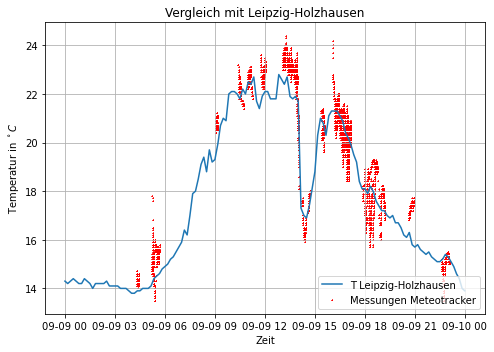

In [6]:
fig,ax3=plt.subplots(1,1, figsize=(7,5))
plt.rc("font", size=10)


ax3.plot(df_compared["T"], label="T "+station)
ax3.scatter(df_compared["time_x"], df_compared["air_temperature"], label="Messungen Meteotracker", s=1, marker="+", color="red")
ax3.set_title("Vergleich mit "+station)
ax3.set_xlabel("Zeit")
ax3.set_ylabel("Temperatur in $^\circ C$")
ax3.grid()
plt.tight_layout()
ax3.legend(loc="lower right")
plt.savefig(f"{plot_path}/"+date+"_time.png", dpi=300, transparent=True)


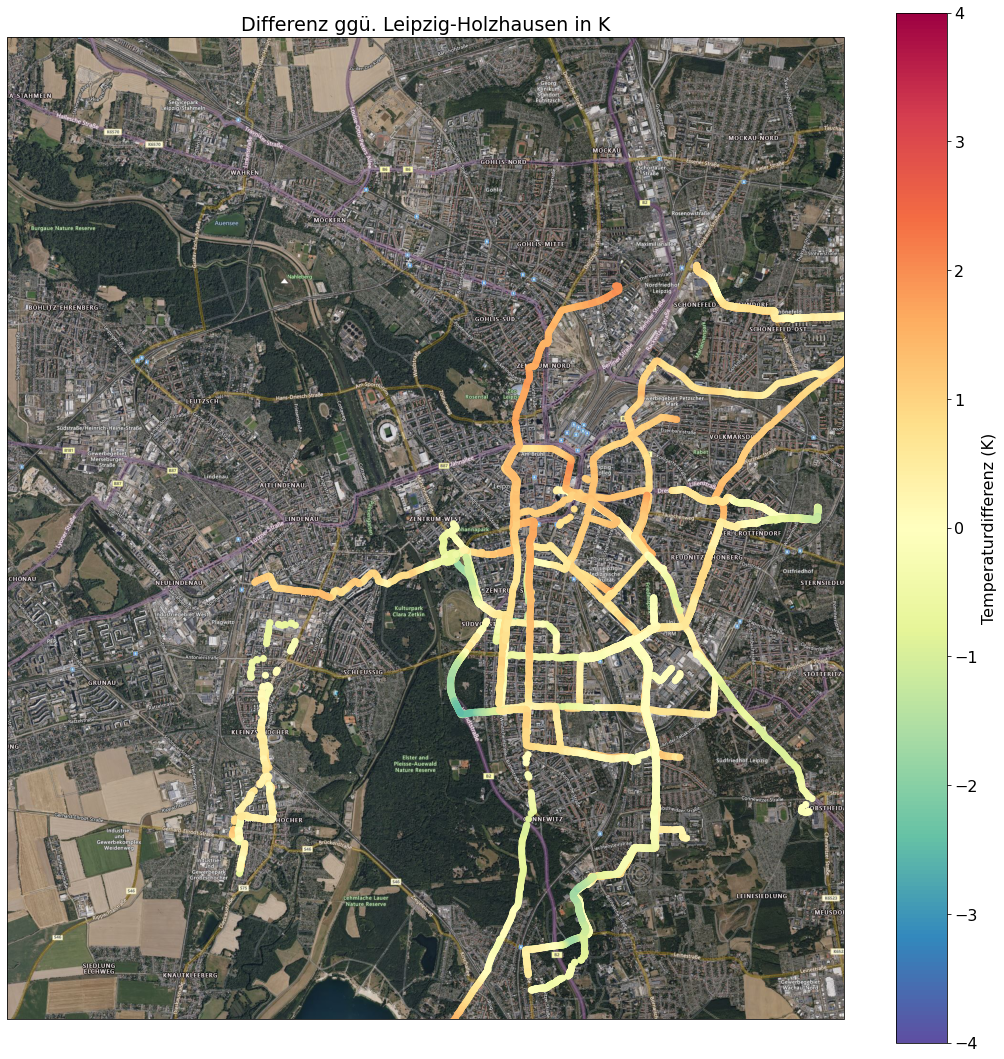

<Figure size 432x288 with 0 Axes>

In [7]:
# %% plot temperature on map and add a nice colorbar
plt.rc("font", size=16)
  # [::100]  # subsample dataframe if needed
request = cimgt.QuadtreeTiles()

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=request.crs))
extent = [ 12.28, 12.43, 51.28,  51.39]  # (xmin, xmax, ymin, ymax)
ax.set_extent(extent)
ax.add_image(request, 14)
scatter = ax.scatter(df_compared["lon"], df_compared["lat"], c=df_compared.T_diff, transform=ccrs.PlateCarree(), cmap="Spectral_r", vmin=-4, vmax=4)
cbar = plt.colorbar(scatter, ax=ax, orientation="vertical", label="Temperaturdifferenz (K)", )
ax.set_title("Differenz ggü. "+station+" in K")
#ax.stock_img()
plt.tight_layout()
plt.show()

plt.savefig(f"{plot_path}/"+date+".png", dpi=300, transparent=True)
#plt.close()


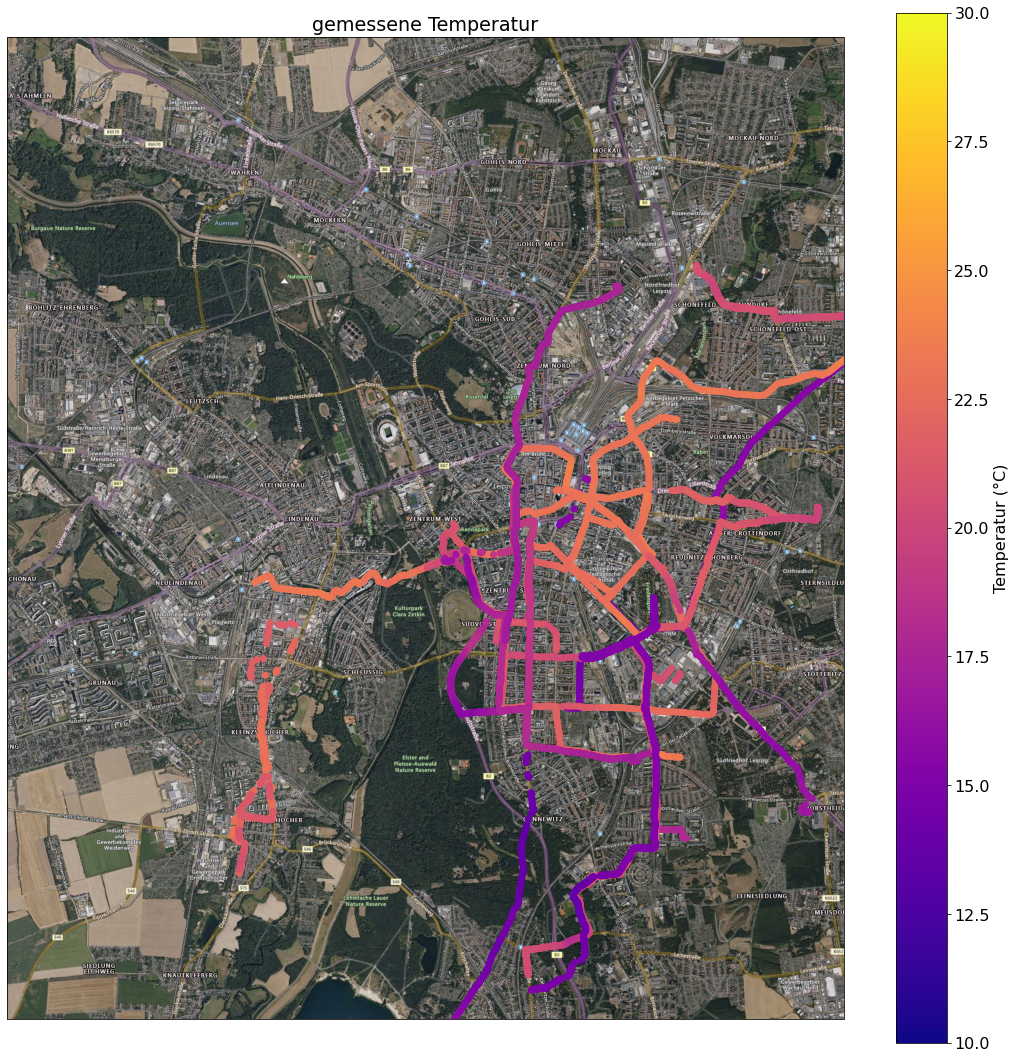

<Figure size 432x288 with 0 Axes>

In [8]:



# %% plot temperature on map and add a nice colorbar
plt.rc("font", size=16)
  # [::100]  # subsample dataframe if needed
request = cimgt.QuadtreeTiles()
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=request.crs))


ax.set_extent(extent)
ax.add_image(request, 14)
scatter = ax.scatter(df_compared["lon"], df_compared["lat"], c=df_compared.air_temperature, transform=ccrs.PlateCarree(), 
                     cmap="plasma", vmin=10, vmax=30)
cbar = plt.colorbar(scatter, ax=ax, orientation="vertical", label="Temperatur (°C)", )
ax.set_title("gemessene Temperatur")
#ax.stock_img()
plt.tight_layout()
plt.show()

plt.savefig(f"{plot_path}/"+date+"_Temp.png", dpi=300, transparent=True)
#plt.close()


In [ ]:
fig, ax=plt.subplots(1,1, figsize=(20,15))
ax_map = map.show_mpl(ax=ax)
x, y = map.to_pixels(df_compared.lat, df_compared.lon)



temp_scatter=ax.scatter(x,y, c=df_compared.hour, cmap="plasma", vmin=18, vmax=20, s=12)
plt.colorbar(temp_scatter, ax=ax)
ax.set_title("Zeit der Vorbeifahrt")

ax.set_ylim(775, 0)
ax.axis("off")



